## EDA Project

---
### 뱅크 샐러드 신용카드 거래

---

#### 가설 1. 저녁 시간대에 카드 결제 금액이 가장 높은 요일은 금요일일 것이다.
#### 가설 2. 평일 오후 2~3시 쯤에 할부 결제 건이 높을 것이다 (직장인들이 점심먹고와서 쇼핑하는시간...ㅎㅎ)
#### 가설 3. holyday에 결제 금액이 높을 것이다 . 결제 건수가 많을 것이다 . 
#### 가설 4. 할부로 긁는 사람 중에 한 번만 이용한 사람은 없다. (서비스 사용 빈도) 
#### 가설 4-1. 할부를 이용하는 사람의 결제액은 할부를 이용하지 않는 사람의 결제액보다 높을 것이다.  

---

In [235]:
import gc
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (15, 8)

### 데이터 탐색

In [469]:
train = pd.read_csv("./Dataset/1st_Competition_data/train.csv")
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,nan,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,nan,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,nan,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,nan,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,nan,0,0


### 데이터 변수

1. store_id 상점 고유번호
2. date 거래일자
3. time 거래시간
4. card_id 카드 번호의 hash 값
5. amount 매출액
6. installments 할부개월수, 일시불은 NaN
7. days_of_week 요일, 월요일이 0, 일요일은 6
8. holyday 1이면 공휴일 아니면 0

In [470]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
store_id        int64
date            object
time            object
card_id         object
amount          int64
installments    float64
days_of_week    int64
holyday         int64
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [471]:
train.describe()

,store_id,amount,installments,days_of_week,holyday
count,3362796.00,3362796.00,16860.00,3362796.00,3362796.00
mean,832.38,145.96,3.46,3.07,0.04
std,546.85,601.73,2.38,1.98,0.21
min,0.00,-250000.00,2.00,0.00,0.00
25%,335.00,32.00,3.00,1.00,0.00
50%,822.00,75.00,3.00,3.00,0.00
75%,1342.00,150.00,3.00,5.00,0.00
max,1799.00,250000.00,36.00,6.00,1.00


---
#### 결측치 확인 및 처리

In [472]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3345936
days_of_week          0
holyday               0
dtype: int64

---
- null data 

    - installments 
    

- installments 은 할부값

    - NaN값은 일시불 결제를 뜻함. 
    - NaN = 1로 대체 가능
    
---

In [474]:
train['installments'] = train['installments'].fillna(1)

In [477]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1.00,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1.00,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1.00,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1.00,2,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1.00,0,0


---

#### 데이터 타입 변경

In [478]:
x = list(train.columns)

train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

train['hour'] = train['time'].apply(lambda x: x[0:2])
train['hour'] = train['hour'].astype('int')

train['weekend'] = train['days_of_week'].apply(lambda x: 1 if x >= 4 else 0)

train['total'] = train['amount'] * train['installments'].astype('int')

train['count'] = train['store_id'].apply(lambda x: 1 if x >= 0 else 0)

In [479]:
train['installments'] = train['installments'].astype(np.int64)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 15 columns):
store_id        int64
date            datetime64[ns]
time            object
card_id         object
amount          int64
installments    int64
days_of_week    int64
holyday         int64
year            int64
month           int64
day             int64
hour            int64
weekend         int64
total           int64
count           int64
dtypes: datetime64[ns](1), int64(12), object(2)
memory usage: 384.8+ MB


In [480]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,weekend,total,count
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1,3,0,2018,7,19,17,0,600,1
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1,3,0,2018,7,19,18,0,275,1
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1,6,0,2018,7,22,14,1,350,1
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1,2,0,2018,7,25,18,0,300,1
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1,0,0,2018,7,30,10,0,325,1


In [481]:
train['count'].count()

3362796

---
#### 상관관계

In [482]:
train.corr()

,store_id,amount,installments,days_of_week,holyday,year,month,day,hour,weekend,total,count
store_id,1.00,0.02,0.00,0.01,0.00,0.01,0.00,-0.00,0.02,0.01,0.01,nan
amount,0.02,1.00,0.18,-0.00,-0.00,-0.01,0.00,0.00,0.01,-0.00,0.68,nan
installments,0.00,0.18,1.00,-0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.44,nan
days_of_week,0.01,-0.00,-0.01,1.00,-0.10,-0.01,0.02,-0.01,-0.02,0.87,-0.00,nan
holyday,0.00,-0.00,-0.00,-0.10,1.00,0.01,-0.02,-0.14,-0.01,-0.08,-0.00,nan
year,0.01,-0.01,-0.00,-0.01,0.01,1.00,-0.60,-0.00,-0.00,-0.00,-0.00,nan
month,0.00,0.00,0.00,0.02,-0.02,-0.60,1.00,0.01,0.00,0.02,0.00,nan
day,-0.00,0.00,0.00,-0.01,-0.14,-0.00,0.01,1.00,0.00,-0.01,0.00,nan
hour,0.02,0.01,-0.00,-0.02,-0.01,-0.00,0.00,0.00,1.00,-0.01,0.00,nan
weekend,0.01,-0.00,-0.00,0.87,-0.08,-0.00,0.02,-0.01,-0.01,1.00,-0.00,nan


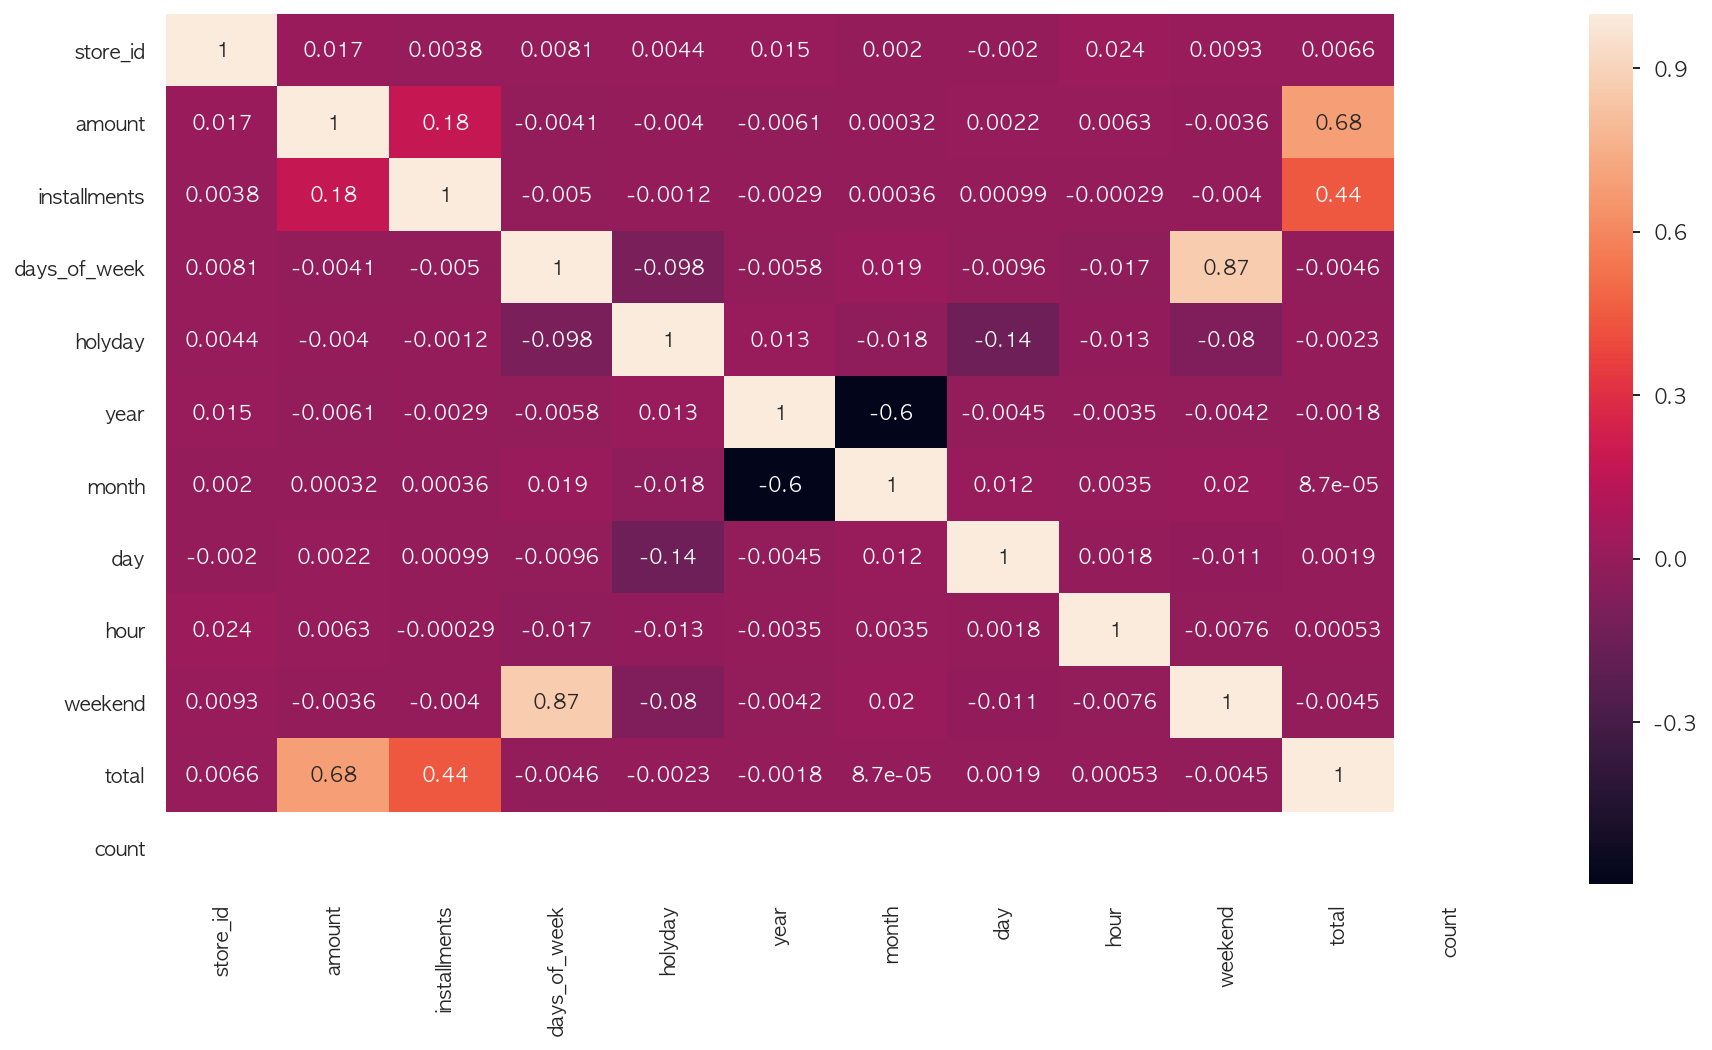

In [483]:
import seaborn as sns
sns.heatmap(train.corr(), annot=True)
plt.show()

---
#### 3-1. 휴일의 결제금액이 높을 것이다. 
#### 3-2. 휴일의 결제 건수가 많을 것이다. 

In [210]:
df = train.pivot_table("amount",'year','days_of_week')
df

days_of_week,0,1,2,3,4,5,6
year,,,,,,,
2016,149.49,160.57,156.32,153.81,157.47,153.19,132.78
2017,143.16,149.64,152.32,152.71,153.69,147.97,133.07
2018,141.06,142.23,143.44,146.36,145.14,143.49,129.04


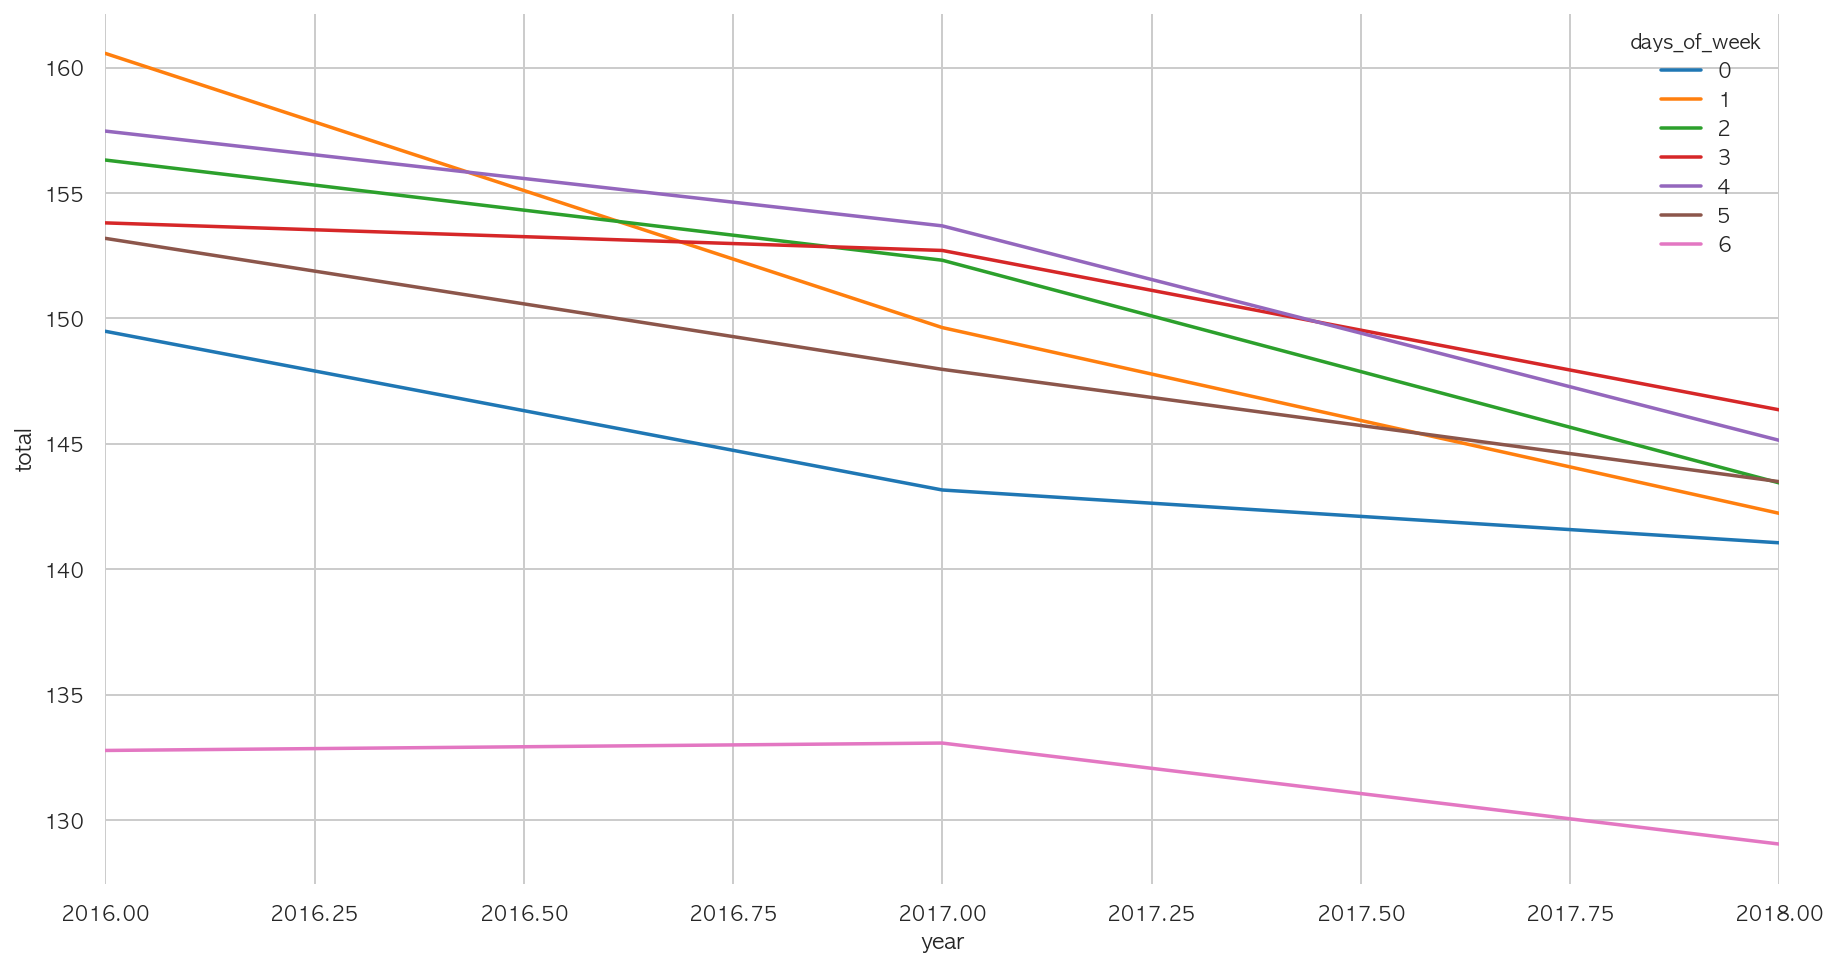

In [52]:
df.plot()
plt.xlabel("year")
plt.ylabel("total")
plt.show()

1. 전체적으로 16년도 사용 금액보다 감소하는 추세를 보인다. 
2. 평일에 비해서 주말에 사용금액이 낮은 것을 볼 수 있다. (특히나 일요일에는 현저하게 낮은 결제금액을 보이고 있다)

In [424]:
df5_week = train.pivot_table('amount','hour','days_of_week')
df5_week.tail()

days_of_week,0,1,2,3,4,5,6
hour,,,,,,,
19,137.88,140.75,148.09,142.33,148.23,158.67,142.21
20,174.74,174.56,181.35,182.16,176.93,167.52,143.44
21,170.55,177.98,178.54,184.03,186.10,159.96,131.59
22,170.89,179.78,175.71,179.63,172.81,150.07,127.20
23,192.12,195.29,198.84,195.68,187.25,158.73,139.93


In [311]:
df5_holy = train.pivot_table('amount','hour','holyday')
df5_holy.tail()

holyday,0,1
hour,,
19,145.77,143.82
20,172.92,150.61
21,172.59,139.73
22,167.62,134.34
23,183.09,147.51


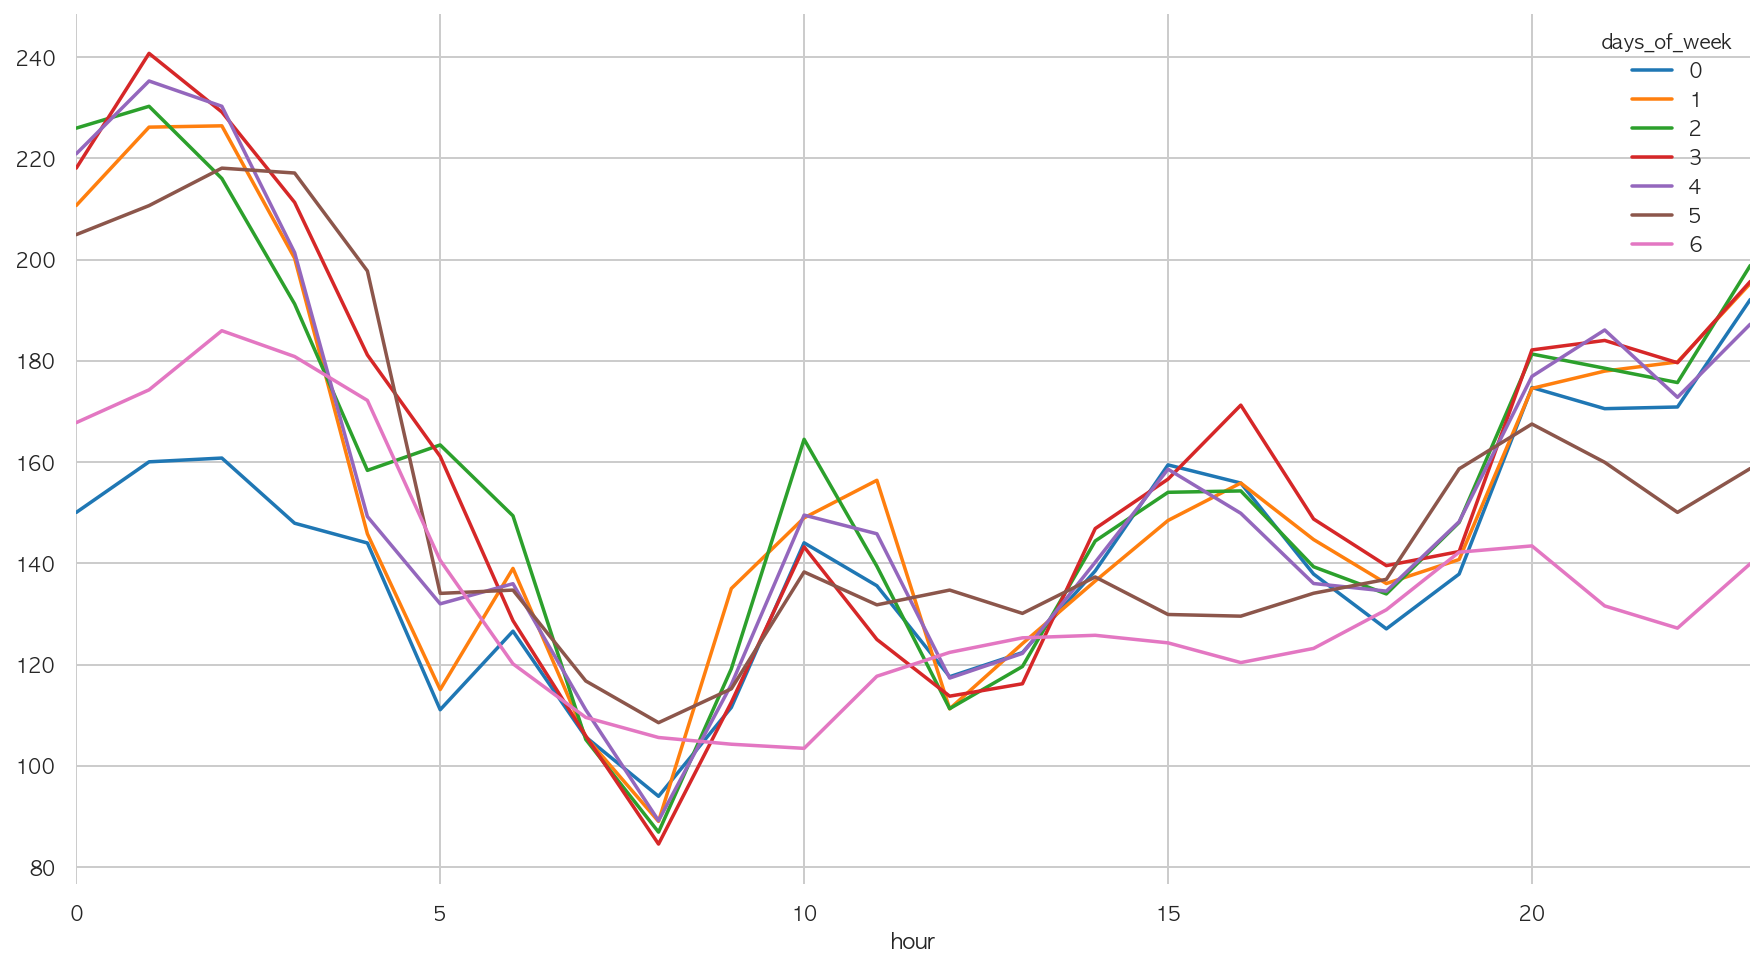

In [425]:
df5_week.plot()
plt.show()

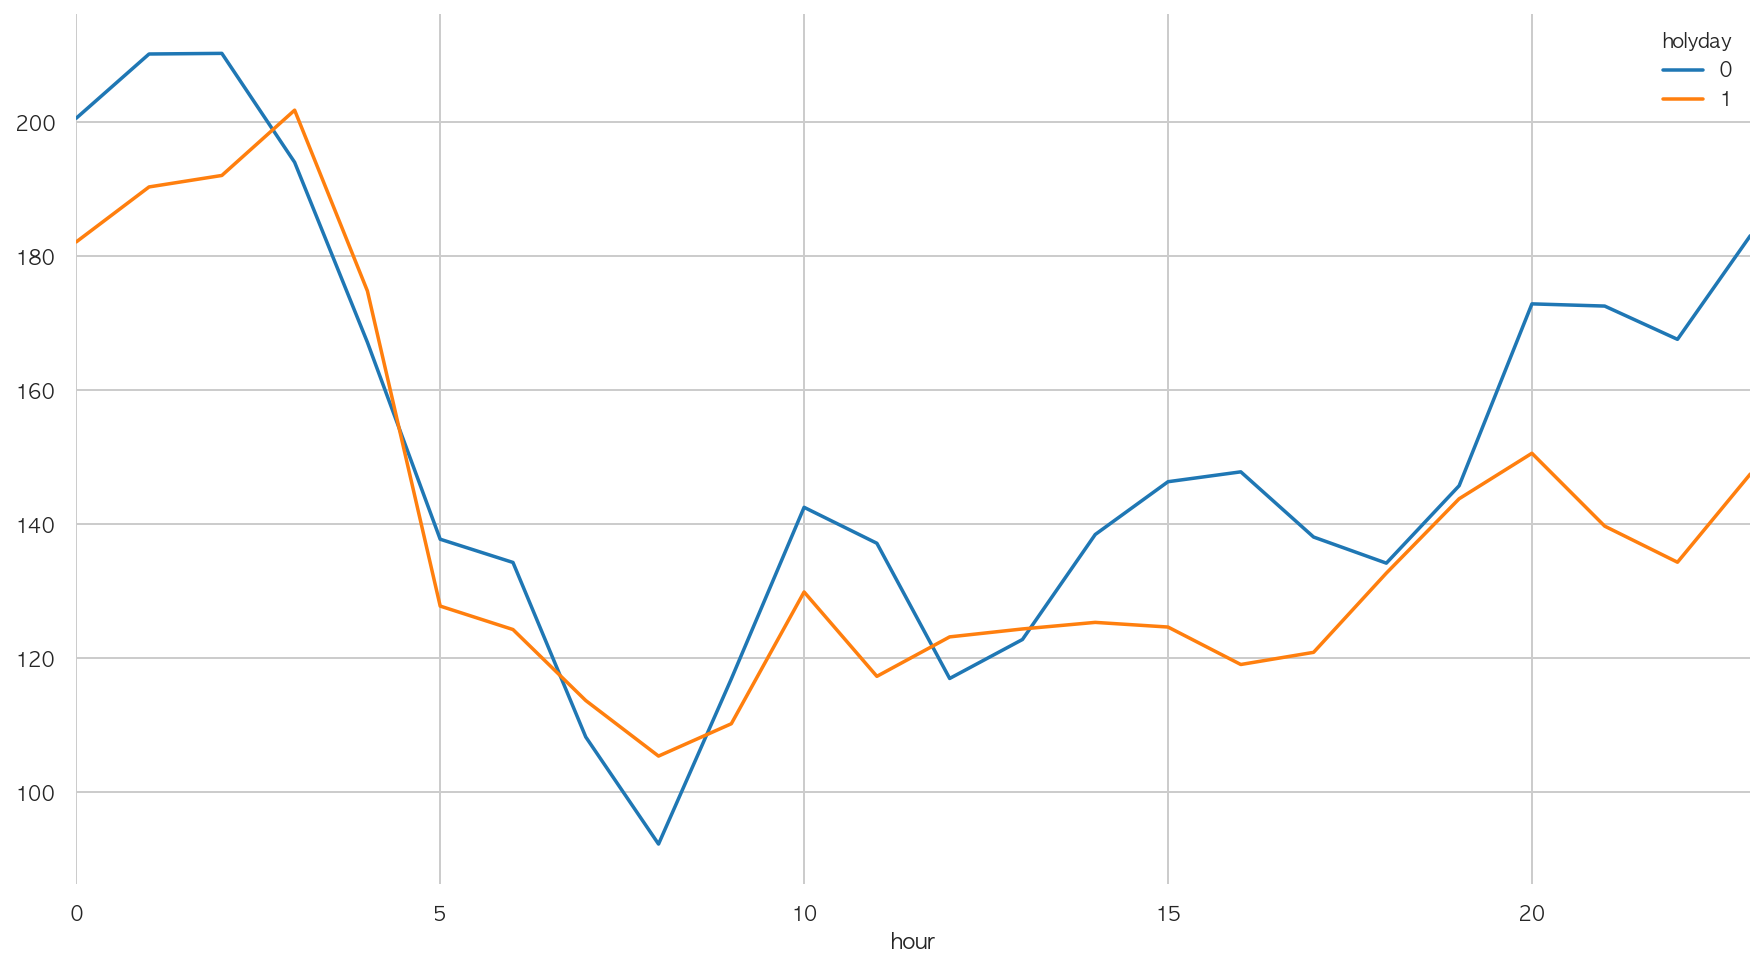

In [313]:
df5_holy.plot()
plt.show()

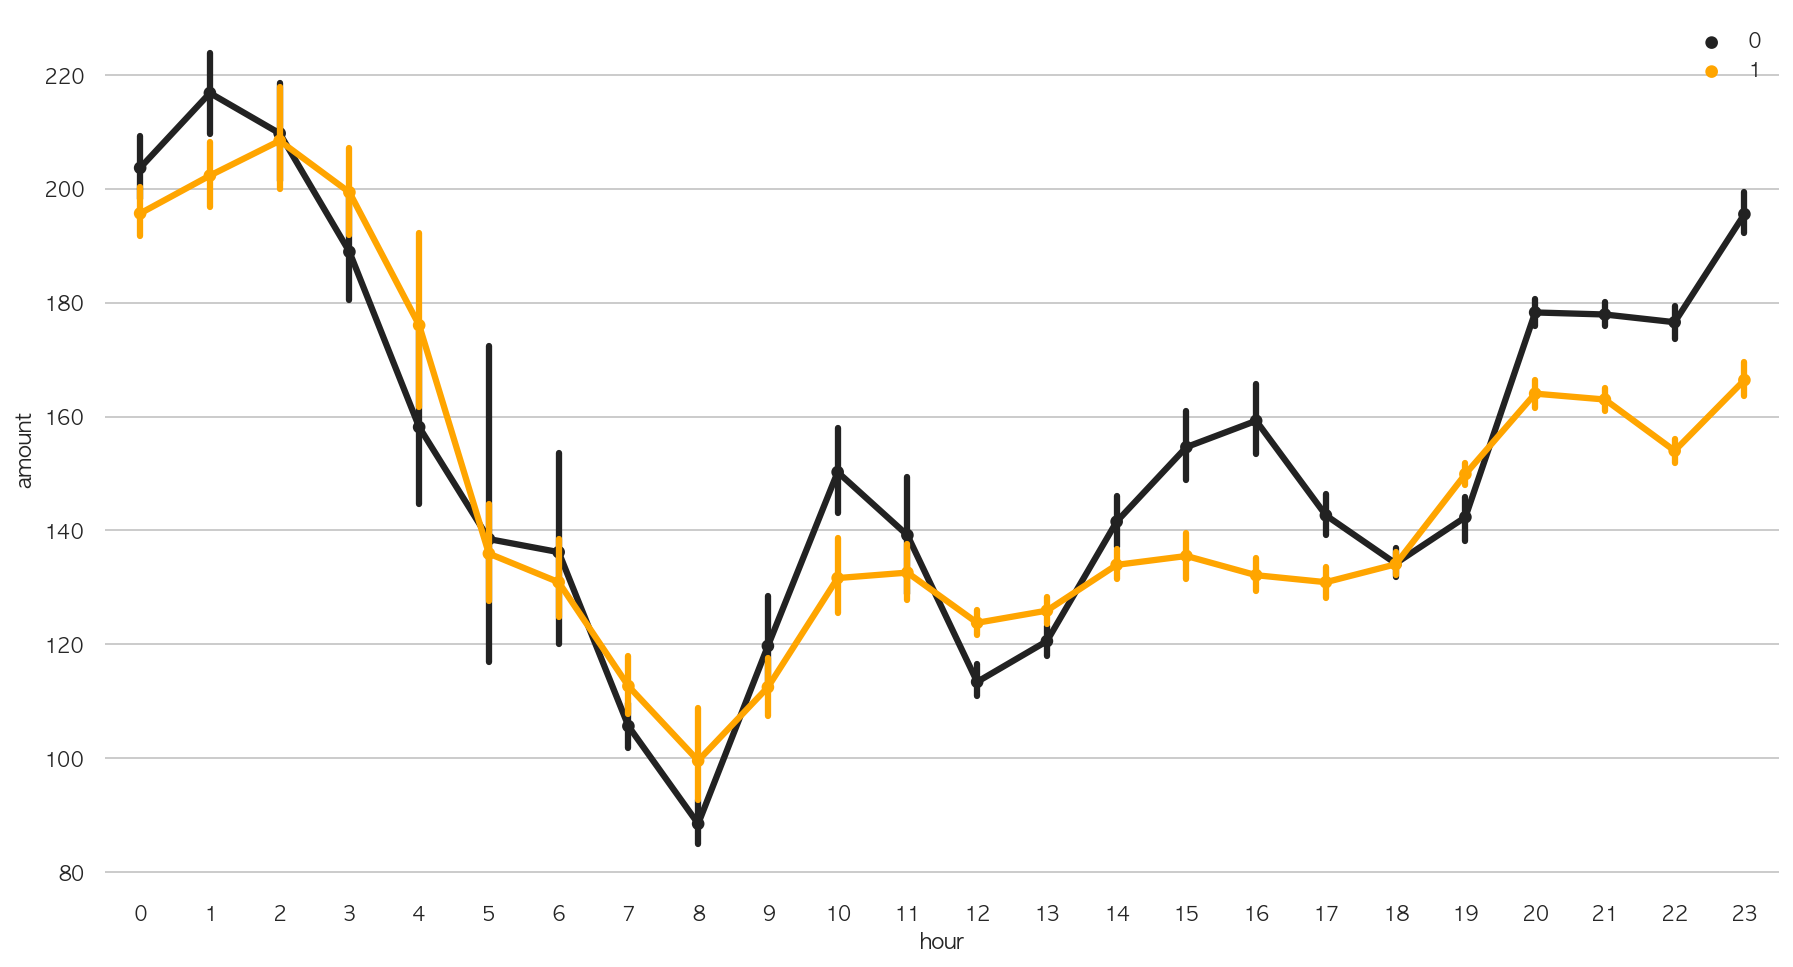

In [294]:
sns.pointplot(x = 'hour', y = 'amount', hue = 'weekend',data = train, color='orange',markers='.')
# sns.pointplot(x = 'hour', y = 'count',hue = 'holyday',data = train, color='green',markers='*')
plt.legend(loc = 1)
plt.show()

1. 휴일인 날과 아닌 날의 그래프는 비슷한 양상을 보인다. 
2. 휴일이면서 주말인 날의 결제

In [225]:
df1 = train.groupby('days_of_week')['total'].mean().reset_index()
df2 = train.groupby('days_of_week')['count'].sum().reset_index()

In [226]:
df1.sort_values('total',ascending=False)

,days_of_week,total
3,3,187.19
1,1,182.15
2,2,181.36
4,4,177.80
0,0,177.56
5,5,167.99
6,6,144.47


####  사용 금액의 평균은 목요일이 가장 높다
---

In [227]:
df2.sort_values('count',ascending=False)

,days_of_week,count
5,5,533093
4,4,511031
3,3,472820
2,2,471573
1,1,467276
6,6,462156
0,0,444847


#### 사용건수는 토요일이 가장 높은 것으로 나타난다. 
---

In [228]:
data1 = df1.merge(df2)
data1

,days_of_week,total,count
0,0,177.56,444847
1,1,182.15,467276
2,2,181.36,471573
3,3,187.19,472820
4,4,177.80,511031
5,5,167.99,533093
6,6,144.47,462156


In [117]:
from sklearn import preprocessing

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(preprocessing.minmax_scale(data1['total']),'r*:', label = 'total')
plt.plot(preprocessing.minmax_scale(data1['count']),'g^--', label = 'count')

plt.xlabel("days_of_week", fontsize = 20)
plt.xticks([0,1,2,3,4,5,6],['월','화','수','목','금','토','일'], fontsize = 14 , rotation = 0)

plt.legend(loc = 0, fontsize = 20)
plt.show()

1. 사용금액은 목요일에 가장 높은 것으로 나타나지만
2. 사용건수는 토요일에 월등히 높은 것으로 보인다. 

In [492]:
train1 = pd.read_csv('./Dataset/1st_Competition_data/train.csv')
train1.head()
train1.dropna(inplace=True)

In [494]:
x1 = list(train1.columns)

train1['date'] = pd.to_datetime(train1['date'])
train1['year'] = train1['date'].dt.year
train1['month'] = train1['date'].dt.month
train1['day'] = train1['date'].dt.day

train1['hour'] = train1['time'].apply(lambda x: x[0:2])
train1['hour'] = train1['hour'].astype('int')

train1['weekend'] = train1['days_of_week'].apply(lambda x: 1 if x >= 4 else 0)

train1['total'] = train1['amount'] * train1['installments'].astype('int')
train1['installments'] = train['installments'].astype(np.int64)

train1['count'] = train1['store_id'].apply(lambda x: 1 if x >= 0 else 0)
train1.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,weekend,total,count
152,0,2016-12-21,10:48:04,65d5e33f69,445,3,2,0,2016,12,21,10,0,1335,1
155,0,2016-12-21,11:16:17,65d5e33f69,-445,3,2,0,2016,12,21,11,0,-1335,1
206,0,2016-12-21,14:26:24,4a8e737d2c,277,2,2,0,2016,12,21,14,0,554,1
311,0,2016-12-21,22:17:30,3f59e8684b,375,3,2,0,2016,12,21,22,0,1125,1
651,0,2016-12-24,11:59:37,583d5dd51c,408,3,5,0,2016,12,24,11,1,1224,1


In [528]:
df4 = train1.pivot_table('count','hour','installments',aggfunc='size')
df4.head()

installments,2,3,4,5,6,7,8,9,10,12,15,18,20,22,24,36
hour,,,,,,,,,,,,,,,,
0,19.00,74.00,3.00,5.00,5.00,nan,nan,nan,3.00,8.00,nan,nan,nan,nan,nan,nan
1,29.00,76.00,2.00,5.00,5.00,nan,nan,nan,3.00,3.00,nan,nan,nan,nan,nan,nan
2,9.00,75.00,1.00,7.00,3.00,nan,nan,nan,3.00,1.00,nan,nan,nan,nan,nan,nan
3,15.00,40.00,nan,2.00,5.00,nan,nan,nan,3.00,nan,nan,nan,nan,nan,1.00,nan
4,5.00,21.00,nan,1.00,3.00,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan


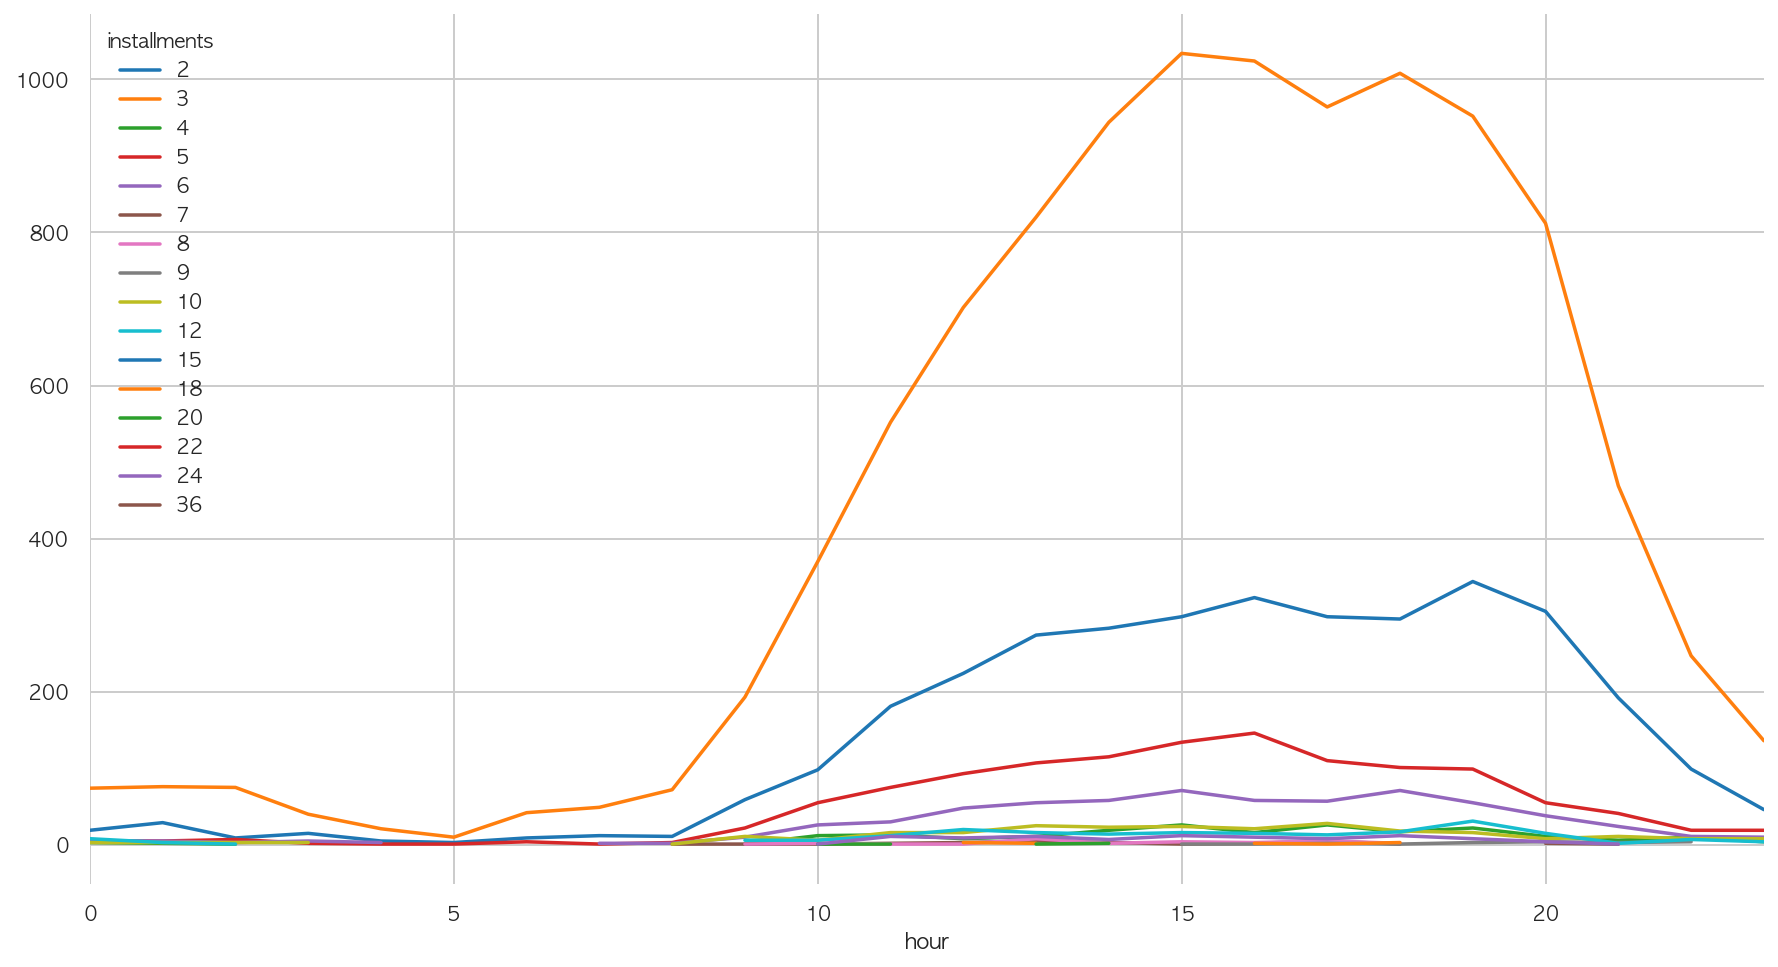

In [530]:
df4.plot()
plt.show()

1. 오전 10-11시, 오후 16-17시, 새벽 시간대의 카드 사용 금액이 높다. 
2. 오전 11시에 카드 사용량이 가장 많고, 

In [539]:
df5 = train1.pivot_table('count','days_of_week','installments',aggfunc='size')
df5

installments,2,3,4,5,6,7,8,9,10,12,15,18,20,22,24,36
days_of_week,,,,,,,,,,,,,,,,
0,438.00,1520.00,27.00,169.00,76.00,5.00,4.00,5.00,45.00,31.00,1.00,3.00,1.00,nan,15.00,3.00
1,467.00,1619.00,44.00,161.00,129.00,5.00,2.00,6.00,56.00,22.00,nan,1.00,nan,nan,16.00,1.00
2,449.00,1529.00,36.00,203.00,84.00,5.00,4.00,2.00,43.00,30.00,nan,4.00,1.00,nan,9.00,nan
3,474.00,1480.00,22.00,180.00,107.00,6.00,5.00,3.00,35.00,39.00,1.00,2.00,nan,4.00,20.00,1.00
4,518.00,1650.00,36.00,177.00,107.00,3.00,8.00,3.00,38.00,33.00,nan,1.00,1.00,nan,21.00,nan
5,644.00,1714.00,27.00,191.00,95.00,2.00,4.00,2.00,23.00,38.00,nan,nan,3.00,nan,15.00,nan
6,441.00,1174.00,17.00,139.00,49.00,2.00,5.00,4.00,12.00,13.00,nan,nan,nan,nan,nan,nan


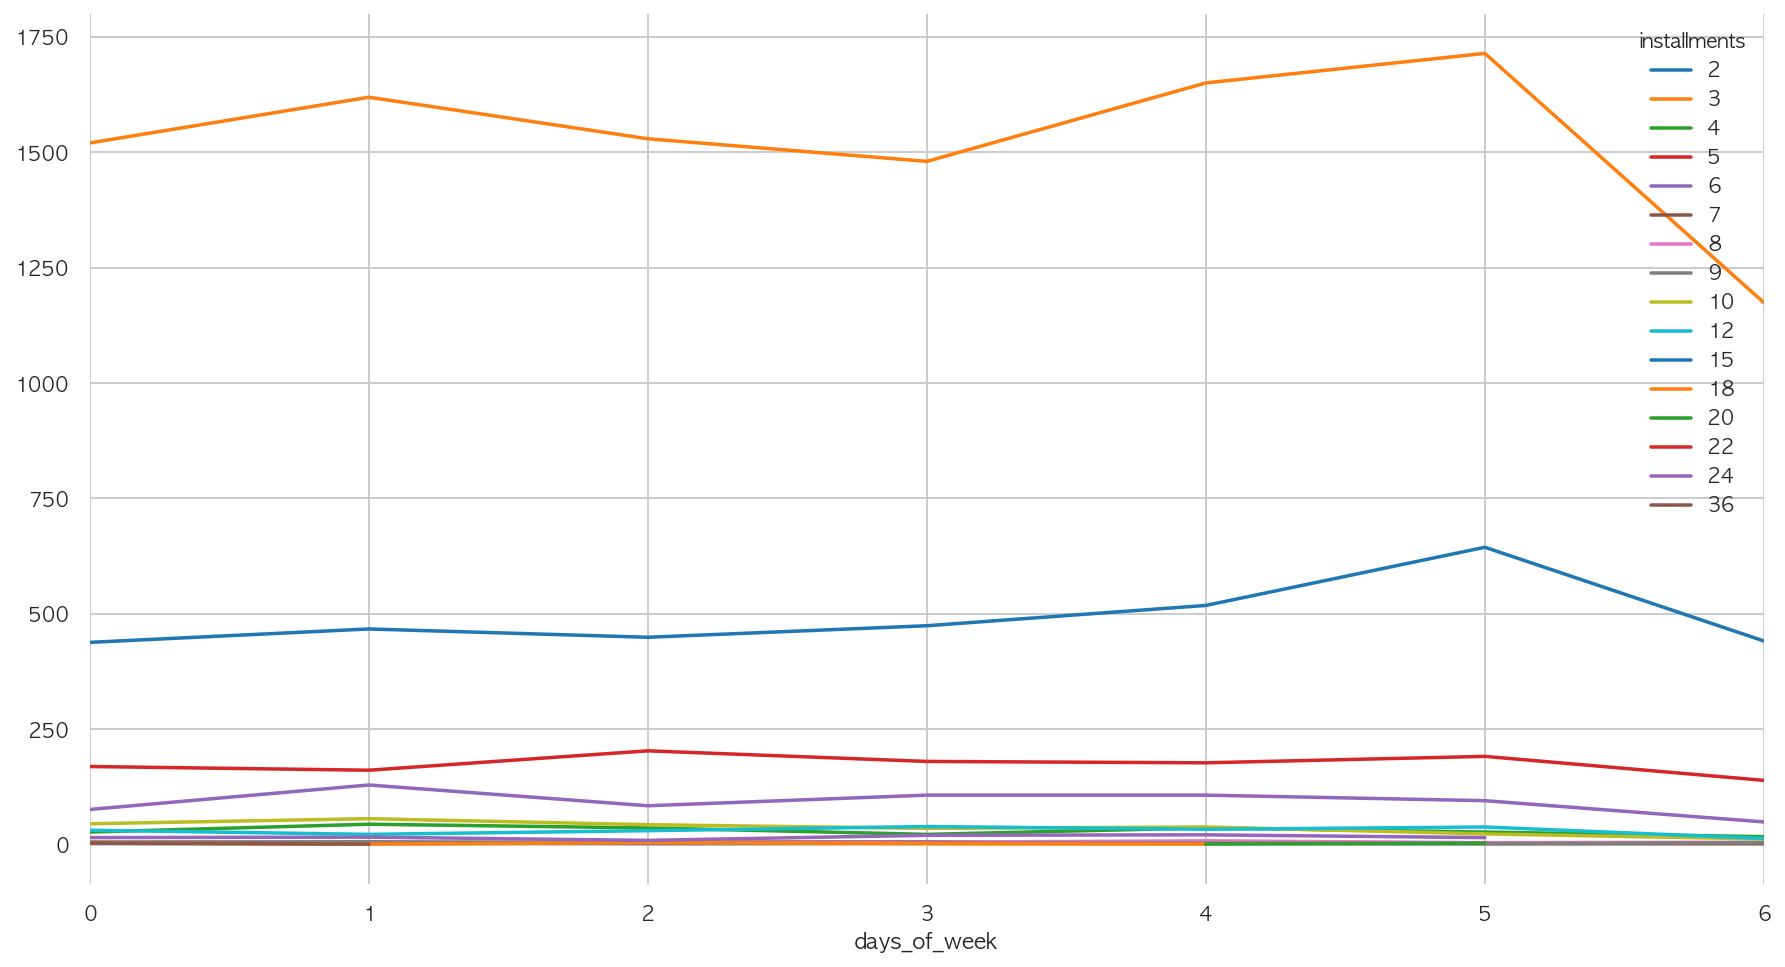

In [543]:
df5.plot()
plt.show()

In [ ]:
# plt.figure(figsize = (10,7))
sns.pairplot(data = train)

In [ ]:
train.plot(x = 'hour' , y = 'day', hue = 'weekend', data = train)
plt.show()

#### 가설 4. 할부로 긁는 사람 중에 한 번만 이용한 사람은 없다. (서비스 사용 빈도) 
#### 가설 4-1. 할부를 이용하는 사람의 결제액은 할부를 이용하지 않는 사람의 결제액보다 높을 것이다.  

In [ ]:
df6 = train.pivot_table("amount",'installments','count')
df6